In [18]:
import plot
from util import get_force_plot_ordering
from scipy.special import logit
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from shap.maskers import Independent
from sklearn.utils import resample, shuffle
import shap
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import dill as pickle
%matplotlib inline
shap.initjs()

In [5]:
with open('classifiers.pickle', 'rb') as f:
    clf_a, clf_b = pickle.load(f)
with open('predictions.pickle', 'rb') as f:
    X, feature_names, n_features, n_samples, indices, pred_a, pred_b = pickle.load(f)

In [6]:
try:
    with open(f'shapvalues.soa.pred.pickle', 'rb') as f:
        shap_values_a, shap_values_b, shap_values_a_vs_b, feature_order = pickle.load(f)
        print('Loaded cached shap values')
except FileNotFoundError:
    print('No cached shap values found')

No cached shap values found


## Generate Explanations

Now we define the functions to be explained:

In [7]:
predict_pred_a = lambda X: clf_a.predict(X)
predict_pred_b = lambda X: clf_b.predict(X)

And now we calculate SHAP values for each function:

In [10]:
%%time

background_data = X
def explain(predict):
    masker = Independent(data=background_data, max_samples=100)
    explainer = shap.Explainer(predict, masker, feature_names=feature_names)
    shap_values = explainer(X)
    return shap_values

shap_values_a = explain(predict_pred_a)
shap_values_b = explain(predict_pred_b)

shap_values_a_vs_b = shap_values_b - shap_values_a
shap_values_a_vs_b.data = shap_values_a.data

feature_order = np.flip(shap_values_a_vs_b.abs.mean(axis=0).values.argsort())

with open(f'shapvalues.soa.pred.pickle', 'wb') as f:
    pickle.dump((shap_values_a, shap_values_b, shap_values_a_vs_b, feature_order), f, pickle.HIGHEST_PROTOCOL)

CPU times: user 6.57 s, sys: 32.3 ms, total: 6.6 s
Wall time: 6.69 s


## Analyze

### Feature Importance

We estimate it with the mean absolute SHAP value (which is the default for this plot) and will also sort features subsequently in this order

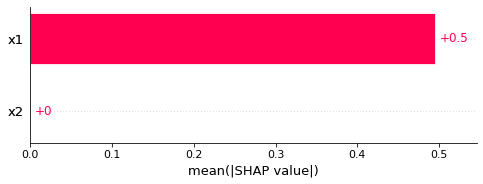

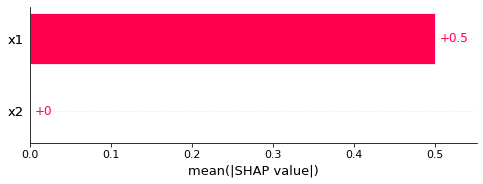

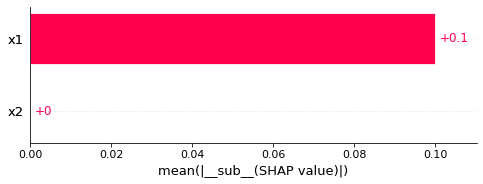

In [11]:
shap.plots.bar(shap_values_a, order=feature_order, max_display=n_features)
shap.plots.bar(shap_values_b, order=feature_order, max_display=n_features)
shap.plots.bar(shap_values_a_vs_b, order=feature_order, max_display=n_features)

### SHAP Value Distribution

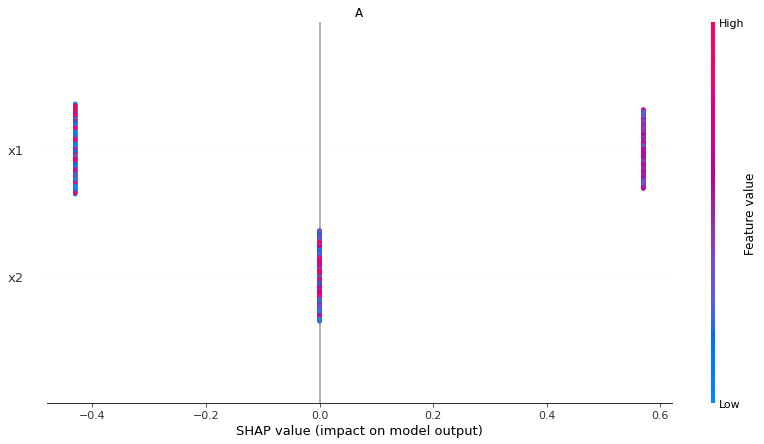

In [12]:
plot.shap_beeswarm(shap_values_a, 'A', order=feature_order, max_display=n_features)

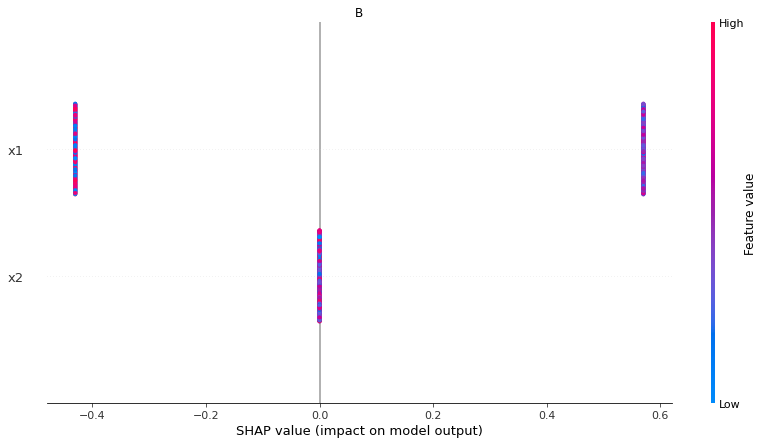

In [13]:
plot.shap_beeswarm(shap_values_b, 'B', order=feature_order, max_display=n_features)

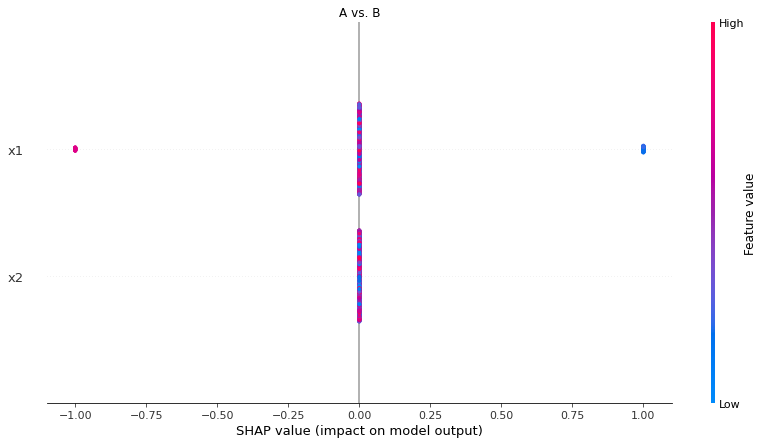

In [14]:
plot.shap_beeswarm(shap_values_a_vs_b, 'A vs. B', order=feature_order, max_display=n_features)

### Features' Partial Dependence Plots

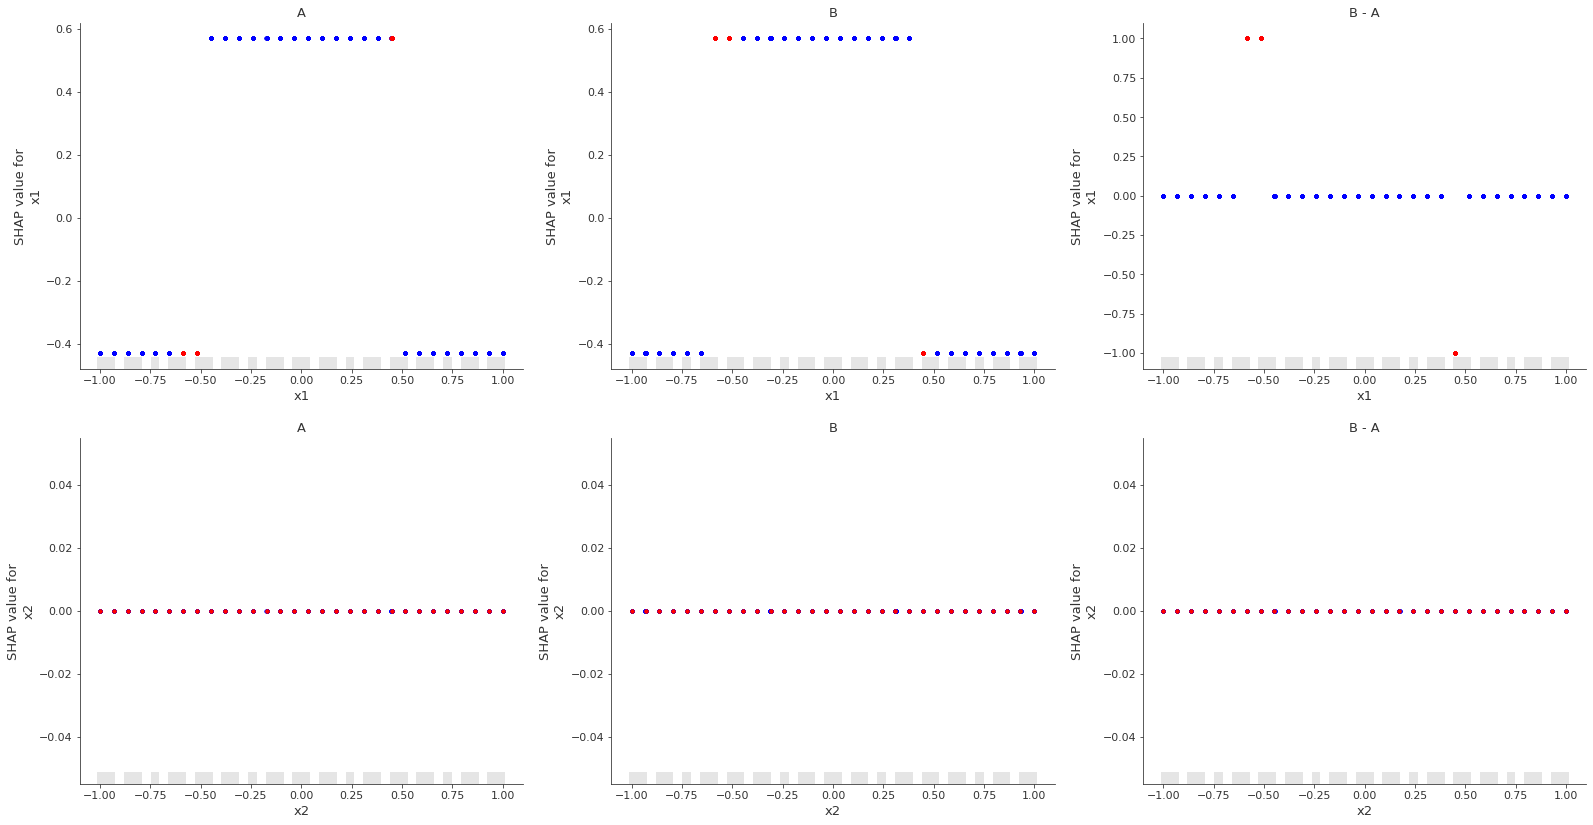

In [15]:
n_columns = 3
n_rows = n_features
fig = plt.figure(figsize=(9*n_columns, 7*n_rows))
i = 1
for feature in feature_names:
    ax1 = fig.add_subplot(n_rows, n_columns, i)
    ax2 = fig.add_subplot(n_rows, n_columns, i+1, sharey=ax1)
    ax3 = fig.add_subplot(n_rows, n_columns, i+2, sharey=None)
    shap.plots.scatter(shap_values_a[:, feature], title='A', ax=ax1, color='blue', show=False)
    shap.plots.scatter(shap_values_a[pred_a != pred_b, feature], title='A', ax=ax1, color='red',  hist=False, show=False)
    shap.plots.scatter(shap_values_b[:, feature], title='B', ax=ax2, color='blue', dot_size=16, show=False)
    shap.plots.scatter(shap_values_b[pred_a != pred_b, feature], title='B', ax=ax2, color='red', hist=False, show=False)
    shap.plots.scatter(shap_values_a_vs_b[:, feature], title='B - A', ax=ax3, color='blue', show=False)
    shap.plots.scatter(shap_values_a_vs_b[pred_a != pred_b, feature], title='B - A', ax=ax3, color='red', hist=False, show=False)
    i += n_columns
plt.show()

### Stacked SHAP Explanations, Clustered by Similarity

In [16]:
idx_diff = indices[pred_a != pred_b]
idx_equal = indices[pred_a == pred_b]
if len(idx_diff) > 500:
    idx_diff = shuffle(idx_diff, random_state=0, n_samples=500)
if len(idx_equal) > 500:
    idx_equal = shuffle(idx_equal, random_state=0, n_samples=500)

In [21]:
ordering = None
for name, shap_values in zip(('A vs. B', 'A', 'B'), (shap_values_a_vs_b, shap_values_a, shap_values_b)):
    shap_values = shap_values[idx_diff]
    plot = shap.plots.force(base_value=shap_values.base_values[0], shap_values=shap_values.values, features=shap_values.display_data, feature_names=shap_values.feature_names, out_names=name, ordering_keys=ordering)
    display(plot)
    if not ordering:
        ordering = get_force_plot_ordering(plot)

In [22]:
ordering = None
for name, shap_values in zip(('A vs. B', 'A', 'B'), (shap_values_a_vs_b, shap_values_a, shap_values_b)):
    shap_values = shap_values[idx_equal]
    plot = shap.plots.force(base_value=shap_values.base_values[0], shap_values=shap_values.values, features=shap_values.display_data, feature_names=shap_values.feature_names, out_names=name, ordering_keys=ordering)
    display(plot)
    if not ordering:
        ordering = get_force_plot_ordering(plot)

### Hierarchically Clustered SHAP Values

Classifier A:

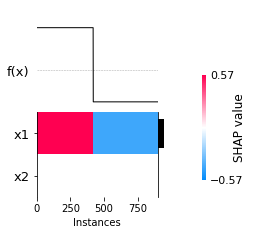

In [27]:
shap.plots.heatmap(shap_values_a, max_display=n_features, feature_order=feature_order)

Classifier B:

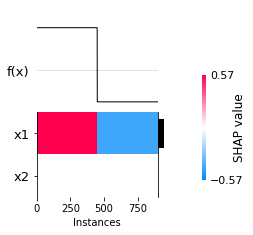

In [28]:
shap.plots.heatmap(shap_values_b, max_display=n_features, feature_order=feature_order)

$s(B)-s(A)$:

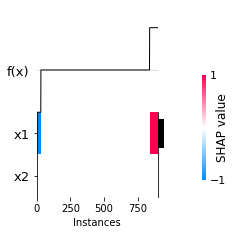

In [29]:
shap.plots.heatmap(shap_values_a_vs_b, max_display=n_features, feature_order=feature_order)